#### 4-1将图像数据转化为Tensor


In [11]:
#加载图像，读出来是array 形式
import imageio
import torch
img_arr = imageio.imread('../data/p1ch4/image-dog/bobby.jpg') 
img_t = torch.from_numpy(img_arr)
#print(img_t)

In [17]:
# 利用permute()函数来改变布局，permute（2，0，1） 新的0 1 2 维度上分别是原来的
#第（2 0 1）维度。但是这并不会改变内存布局。 原来是（HWC）->(C H W)
out = img_t.permute(2, 0, 1) # 类似于transpose 函数
img_t.stride(),img_t.shape,out.stride(),out.shape

((3840, 3, 1),
 torch.Size([720, 1280, 3]),
 (1, 3840, 3),
 torch.Size([3, 720, 1280]))

In [19]:
#除了读数组出来转化为tensor的思路以外，我们还可以利用设置一个tensor，然后读文件数据去
#填充的思路
batch_size = 3
batch = torch.zeros(batch_size,3,256,256, dtype = torch.uint8)

In [30]:
import os
data_dir = '../data/p1ch4/image-cats/'
#获取该目录下所有png图片的名字
filenames = [name for name in os.listdir(data_dir) 
             if os.path.splitext(name)[-1] == '.png'] 
print(filenames)
for i, filename in enumerate(filenames): 
    img_arr = imageio.imread(os.path.join(data_dir,filename))
    img_t = torch.from_numpy(img_arr)
#     print(img_t.shape)
    img_t = img_t.permute(2, 0, 1) # C H W-  
#     print(img_t.shape)
    img_t = img_t[:3] # 只要0 1 2两个维度？
    batch[i] = img_t
print("batch shape:")
for i ,data in enumerate(batch):
    print("batch ",i,"shape:",data.shape)

['cat1.png', 'cat2.png', 'cat3.png']
batch shape:
batch  0 shape: torch.Size([3, 256, 256])
batch  1 shape: torch.Size([3, 256, 256])
batch  2 shape: torch.Size([3, 256, 256])


由于神经网络通常用浮点数张量作为输入，所以我们需要对图像的输入做：
1. 浮点数的转化
2. 归一化的处理。

对归一化要进一步解释：
1. **为什么要做归一化**


归一化的主要目的是让数据范围在一定区间（如 [0, 1] 或 [-1, 1]）内，这样可以提高神经网络的训练效率和稳定性。
1) 可以加快收敛速度，神经网络中的权重和偏执利用方向传播进行更新，如果数据范围差距很大，会导致损失安徽念书的梯度剧烈变化，优化器需要更长时间找到最优解。由此，归一化可以让梯度更加平滑，加快训练的收敛速度。
2) 设定好数值训练范围，可以防止训练中的数据溢出
3) 避免有输入数据的默写特征值范围远大于其他特征，在训练中占主导地位，归一化可以平衡各个特征的重要性


总而言之，归一化可以让数据分布更加标准化，让模型更快、更好的拟合数据、避免数据溢出的风险。

2. **如何进行归一化**

归一化有不同的计算方法，我们分别介绍如下
1) Min-Max Scaling (最小-最大归一化)   x` = (x - x_min)/(x_max - x_min)

2) Standardization (标准化)   x` = (x - u)/(σ)

3) Mean Normalization (均值归一化)   x` = (x - u) / (x_max - x_min)

4) Decimal Scaling (小数缩放)

其中**σ**是标准差，**u**是均值。标准差的计算方法是

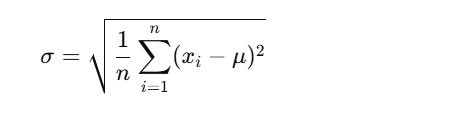

In [36]:
batch = batch.float()
batch /= 255.0 
batch.shape
print(batch.shape[1])

3


In [46]:
n_channels = batch.shape[1] # NCHW 取C维度,就是对RGB这三个维度进行归一化处理
for c in range(n_channels): 
    mean = torch.mean(batch[:, c])  # 这里就是获取 NCHW （N H W ）的数据切片 
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std # 采用的是标准化的方式来归一化
    #print("batch[:, {:}]  shape: ".format(c),batch[:, c].shape,"\r\n",batch[:, c])

读取CT扫描件　DICOM 格式。volread 会将DICOM格式读取为一个三维度数组。由于DICOM 颜色都是单通道。C=1,所以读取出来只会有三维数据 DHW.

In [52]:
# 读取CT扫描样本,但是 这个并没有读出来C D通道，书上写得是 N C D H W格式
import imageio
#dir_path = "W:\apps\pytorch\jupyter_Notebook\data\p1ch4\volumetric-dicom\2-LUNG 3.0  B70f-04083"
dir_path = "../data/p1ch4/2-LUNG" 
vol_arr = imageio.volread(dir_path, 'DICOM')# 使用的是volread 的函数
print("vol_arr shape: ",vol_arr.shape)
#利用unsqueeze 函数来多一个patch维度。
vol_t = torch.from_numpy(vol_arr)
vol_t = torch.unsqueeze(vol_t,0)
print("vol_t shape: ",vol_t.shape)

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 46/99  (46.596/99  (97.099/99  (100.0%)
vol_arr shape:  (99, 512, 512)
vol_t shape:  torch.Size([1, 99, 512, 512])


**4-3 读取表格数据**

In [62]:
# 加载CSV文件。使用的是numpy 来读取
import csv 
import numpy as np
wine_path = "../data/p1ch4/tabular-wine/winequality-white.csv" 
# delimiter=";" 表示数据是以';'表示的，skiprows = 1 ,表示第一行的数据不要。
wineq_numpy = np.loadtxt(wine_path,dtype=np.float32,delimiter=";",skiprows=1)
print(wineq_numpy.shape,wineq_numpy.dtype)

#读取 CSV文件的第一行表头
#col_list = next(csv.reader(open(wine_path), delimiter=';')) 
col_list = np.loadtxt(wine_path,dtype=str,delimiter=";",max_rows=1)
print(col_list)

#将数据转化为tensor
wineq_t = torch.from_numpy(wineq_numpy)
print(wineq_t.shape,wineq_t.dtype)
wineq_t

(4898, 12) float32
['"fixed acidity"' '"volatile acidity"' '"citric acid"' '"residual sugar"'
 '"chlorides"' '"free sulfur dioxide"' '"total sulfur dioxide"'
 '"density"' '"pH"' '"sulphates"' '"alcohol"' '"quality"']
torch.Size([4898, 12]) torch.float32


tensor([[ 7.0000,  0.2700,  0.3600,  ...,  0.4500,  8.8000,  6.0000],
        [ 6.3000,  0.3000,  0.3400,  ...,  0.4900,  9.5000,  6.0000],
        [ 8.1000,  0.2800,  0.4000,  ...,  0.4400, 10.1000,  6.0000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  0.4600,  9.4000,  6.0000],
        [ 5.5000,  0.2900,  0.3000,  ...,  0.3800, 12.8000,  7.0000],
        [ 6.0000,  0.2100,  0.3800,  ...,  0.3200, 11.8000,  6.0000]])

关于数值的阐述：
1. 连续值，表示是有实际意义的值，比如长度为5cm、6cm、10cm 这种类似的。
2. 序数值：表示序列大小排列严格存在，就像小杯、中杯、大杯分别为1 2 3，但是这种没有明确的数字计算关系，不能说 3 = 2 +1 
3. 分类值：没有明确的数学关系，只是用于分类。1表示草、2表示牛 等等


In [77]:
#对于最后一个标签“quality”，我们可以把它当作 一个实数执行回归任务。或者把
#其当作一个标签，用于最后的分数猜测。

data = wineq_t[:,:-1] # 数据删除了quality
data,data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [74]:
#取出最后一列
target = wineq_t[:,-1].long()
target,target.shape,target.shape[0]

(tensor([6, 6, 6,  ..., 6, 7, 6]), torch.Size([4898]), 4898)

接下来我们将会使用one-hot encoding。One-Hot Encoding 是一种将分类数据（即非数值数据，如类别标签）转换为数值表示的技术，主要用于机器学习和深度学习中处理离散数据。假设我们有一个分类变量（例如颜色类别）：["Red", "Green", "Blue"]。如果直接将这些类别用数字表示（如 0, 1, 2），会让模型误以为这些数字之间有大小关系或连续性（即模型可能会认为 2 > 1 > 0），这会导致错误的学习结果。为了解决这个问题，One-Hot Encoding 将每个类别表示为一个独立的二进制向量：

* 每个类别的向量中，只有一个位置是 1，其他位置是 0。
* 向量的长度等于类别的总数。
就会变成下面这样
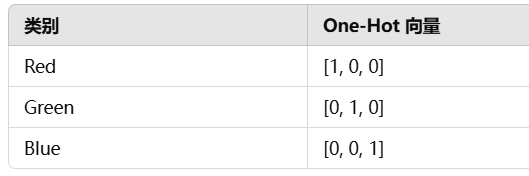

In [76]:
#注意这里用target.shape 就不行，因为不是数据类型
target_onehot = torch.zeros(target.shape[0], 10) 

#tensor.scatter_(dim, index, src)
#dim：在哪个维度上进行填充，这里是1 表示在列的方向上填充？
#index：索引张量，指定要填充的张量
#src：要填充的索引值，这里1.0 表示one_shot 中为1的位置
# scatter_ 名字后面的下划线，不会返回一个新的张量，会修改当前张量
#  
target_unsqueeeze  = target.unsqueeze(1)
print(target_unsqueeeze) # 增加一个维度 由（4898）变成 [4898,1]了
target_onehot.scatter_(1, target_unsqueeeze, 1.0) 

tensor([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [92]:
# 沿着列的方向，计算每一列的平均数，即获取每一个标签的数据。
data_mean = torch.mean(data,dim = 0)
#同样获取每一列的标准差-实际var 是方差
data_var = torch.var(data,dim = 0)
print(data_mean,data_var)
#然后我们来进行归一化操作-标准差是方差的
data_normalized = (data - data_mean)/torch.sqrt(data_var)
data_mean,data_var 


tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01]) tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])


(tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
         1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01]),
 tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
          -3.4915e-01, -1.3930e+00],
         [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
           1.3422e-03, -8.2419e-01],
         [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
          -4.3677e-01, -3.3663e-01],
         ...,
         [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
          -2.6153e-01, -9.0545e-01],
         [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
          -9.6251e-01,  1.8574e+00],
         [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
          -1.4882e+00,  1.0448e+00]]))

In [83]:
#torch 提供比较函数，也可以用torch.le(target,3)
bad_index = target<=3  #找出最后一列中 小于3的分数

#发现是个bool的变量,会把对应小于3的设置为true
print(bad_index)
bad_index.shape,bad_index.dtype,bad_index.sum() 


tensor([False, False, False,  ..., False, False, False])


(torch.Size([4898]), torch.bool, tensor(20))

In [93]:
#高级索引功能，直接能找到那20个索引
bad_data = data[bad_index]
bad_data.shape,bad_data
#根据最后一列的目标分组
bad_data = data[target <=3]
mid_data = data[(target > 3) & (target < 7)]
good_data = data[target >7]

#列方向求平均
bad_mean = torch.mean(bad_data,dim = 0)
mid_mean = torch.mean(mid_data,dim = 0)
good_mean = torch.mean(good_data,dim = 0)
print(bad_mean,'\r\n',mid_mean,'\r\n',good_mean)

#列方向打印出来
for i ,args in enumerate(zip(col_list,bad_mean,mid_mean,good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i,*args))

tensor([7.6000e+00, 3.3325e-01, 3.3600e-01, 6.3925e+00, 5.4300e-02, 5.3325e+01,
        1.7060e+02, 9.9488e-01, 3.1875e+00, 4.7450e-01, 1.0345e+01]) 
 tensor([6.8869e+00, 2.8153e-01, 3.3644e-01, 6.7051e+00, 4.7841e-02, 3.5424e+01,
        1.4183e+02, 9.9447e-01, 3.1808e+00, 4.8707e-01, 1.0265e+01]) 
 tensor([6.6783e+00, 2.7797e-01, 3.2817e-01, 5.6283e+00, 3.8011e-02, 3.6628e+01,
        1.2588e+02, 9.9221e-01, 3.2212e+00, 4.8567e-01, 1.1651e+01])
 0 "fixed acidity"        7.60   6.89   6.68
 1 "volatile acidity"     0.33   0.28   0.28
 2 "citric acid"          0.34   0.34   0.33
 3 "residual sugar"       6.39   6.71   5.63
 4 "chlorides"            0.05   0.05   0.04
 5 "free sulfur dioxide"  53.33  35.42  36.63
 6 "total sulfur dioxide" 170.60 141.83 125.88
 7 "density"              0.99   0.99   0.99
 8 "pH"                   3.19   3.18   3.22
 9 "sulphates"            0.47   0.49   0.49
10 "alcohol"             10.34  10.26  11.65


In [96]:
#查看了各个参数的平均值之后，我们利用`total sulfur dioxide` 这个因素来区分好酒和坏酒
total_sulfur_threshold = 141.83 
total_sulfur_data = data[:,6] 
#predicted_indexes = total_sulfur_data<total_sulfur_threshold
#判断 total sulfur dioxide < 141.83 就为好酒
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold) 
predicted_indexes.shape,predicted_indexes.sum()

(torch.Size([4898]), tensor(2727))

In [97]:
#实际好酒的数量
actual_indexes = target > 5 
actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum() 

(torch.Size([4898]), torch.bool, tensor(3258))

In [99]:
#利用&的操作，来确定预测的是在原来好酒的数据集里面
n_matches = torch.sum(actual_indexes & predicted_indexes).item() 
n_predicted = torch.sum(predicted_indexes).item() 
n_actual = torch.sum(actual_indexes).item() 
#预测成功数量、成功数量在预测中的比例、成功数量在实际中的比例，分别为
# 精确率（Precision） = 预测为正的样本中，真正例的比例。
# 召回率（Recall） = 实际为正的样本中，被正确预测的比例
print(n_matches, n_matches / n_predicted, n_matches / n_actual )

2018 0.74000733406674 0.6193984039287906
